# Network Analytics - Custom Centrality Measures
## Identifying at risk students from phone call records


----------------------------


<div style="border:1px solid black;padding: 25px;;radius:5px">
<h1>Brief</h1><br> A high-school Suicide and Distress Counseling service has data on the phone calls between 27 high-school students (a who-talks-to-whom network). One of its directors believes network analytics will help it proactively monitor and help students in distress.<br><br>
One of the concerns in sociology of young adults is the prevalence of suicide-pacts between pairs of friends. The Director wants to come up with a measure so that if they identify a person as potentially troubled, they can identify a “paired” subject that they can reach out pro-actively to assess suicide risk. It is known that potential at-risk students become increasingly withdrawn<br><br>
<b>Given this information, develop a centrality measure which identifies the most at risk students in the network.</b>
  
</div>

--------------------------------------

## Contents
[1. Introduction](#intro)  
&nbsp;&nbsp; [1.1 Executive Summary](#es)  

[2. Exploratory Data Analysis](#eda)    
&nbsp;&nbsp; [2.1 Import data](#import)  
&nbsp;&nbsp; [2.2 Feature Analysis](#fa)  
&nbsp;&nbsp;&nbsp;&nbsp; [2.2.1 General](#general)  
&nbsp;&nbsp;&nbsp;&nbsp; [2.2.2 User and Other](#userandother)  
&nbsp;&nbsp;&nbsp;&nbsp; [2.2.3 Direction](#direction)  
&nbsp;&nbsp;&nbsp;&nbsp; [2.2.4 Duration](#duration)  
&nbsp;&nbsp;&nbsp;&nbsp; [2.2.5 Timestamp](#ts)  
&nbsp;&nbsp;&nbsp;&nbsp; [2.2.6 Summary of data cleaning](#dataclean)  
&nbsp;&nbsp; [2.3 Initial Network Analysis](#na)  

[3. Model Hypothesis and Reasoning](#modelhypothesis) 

[4. Implementation](#implementation)   
&nbsp;&nbsp; [4.1 Calculate influence](#calculateinfluence)  
&nbsp;&nbsp; [4.2 Calculate loneliness factor](#loneliness)  
&nbsp;&nbsp; [4.3 Predict paired students](#paired)  
&nbsp;&nbsp; [4.4 Model Pairings](#pairings)  
&nbsp;&nbsp; [4.5 Network visualisation](#naviz)  
&nbsp;&nbsp; [4.6 Model evaluation](#evaluation)  
&nbsp;&nbsp;&nbsp;&nbsp; [4.6.1 Load and clean messages data](#messages)  
&nbsp;&nbsp;&nbsp;&nbsp; [4.6.2 Calculate pairings for messages data](#messagepairings)  
&nbsp;&nbsp;&nbsp;&nbsp; [4.6.3 Compare model predictions](#predictions)  

[5. Conclusions](#conclusions)

-----------------
<a id=intro></a>
## 1. Introduction

Suicide pacts between students is a [concern](https://www.tandfonline.com/doi/abs/10.1080/00098655.2011.564981) in sociology of young adults. Analysis of student networks can yield important information about relationships between students and identify which students have close relationships and could be in a suicide pact with each other. Should an 'important' member of the network become a suicide risk, it might be possible to proactively reach out to other 'close by' members of the network to help them. 

This analysis project uses the phone call records of 27 students to extract information about the most influential nodes in the network and also assess behavioural information such as how many calls they make or how many different people they are interacting with. These insights will be used to develop a method of predicting which students in the network might be involved in a suicide pact given that another member in the network has already been identified as at risk. This information can be used by the student support team to proactively reach out to at risk students.  


<a id=es></a>
### 1.1 Executive Summary

The phone call records of 27 students at a school were analysed to identify important connections between students and between mutual third parties in the network. A centrality measure was proposed to identify which connected parties were most at risk of suicide given that a student already in the network had been identified as at risk of suicide. i.e. which nodes have influence over over nodes in the network. The centrality measure used two terms, the strength of relationship between a students and the 'reclusiveness' of an individual, to calculate a risk score. Students who had a strong relationship with the target node and exhibited signs of reclusiveness were deemed as higher risk. No 'ground truth' is known for this network so the effectiveness of the centrality measure was tested by applying it to the text message records of the students to assess if the same outcome was reached. The same students were indeed identified as at risk on both the phone call records dataset and the text messages dataset.


------

-------------------------------
## Import libraries

In [1]:
#data manipulation
import pandas as pd
import numpy as np

#network analysis
import networkx as nx

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#date manipulation
import dateutil.relativedelta as rel

#display html in output
from IPython.core.display import display, HTML

In [2]:
#filter warnings for final presentation
import warnings
warnings.filterwarnings("ignore")

----------------------
<a id=eda></a>
## 2 Exploratory data analysis

Before deciding on a centrality metric, it is important to understand the key features of the dataset which are available for our model, but also identify any outliers, missing data or errors which may have an impact on the analysis.

Two datasets for this problem were given alongside the brief. The data is given 'as is' and there is no additional information or context given for each dataset so assumptions will have to be made as to what each attribute represents:

__high_school_calls.csv__
- contains the incoming and outgoing phone records of the 27 students. This includes calls between the 27 students and also calls their to external parties.
- attributes:
    - user
    - other
    - direction
    - duration
    - timestamp
            
__high_school_messages.csv__
- contains the a record of text messages sent between the 27 students and messages sent to external parties.
- attributes:
    - user
    - other
    - direction 
    - length
    - timestamp


The following is a summary of the key findings from a detailed analysis of the dataset including the most important findings.

<a id=import></a>
### 2.1 Import data

In [51]:
#read the csv data
#specify dtypes as 'user' is read differently to 'other'
raw_calls_df = pd.read_csv("high_school_calls.csv", dtype={'user':str,'other':str,'direction':str,'duration':int})

#convert timestamp column from object to datetime
raw_calls_df['timestamp'] = pd.to_datetime(raw_calls_df['timestamp'],utc=True)

#first few rows of raw data imported from csv file
raw_calls_df.head(5)

,user,other,direction,duration,timestamp
0,07610039694,07434677419,Incoming,211,2010-09-15 18:17:44+00:00
1,07641036117,01666472054,Outgoing,31,1980-02-11 07:18:23+00:00
2,07641036117,07371326239,Incoming,45,1980-02-11 07:45:42+00:00
3,07641036117,07681546436,Outgoing,10,1980-02-11 08:04:42+00:00
4,07641036117,07681546436,Outgoing,0,1980-02-11 08:05:31+00:00


<a id=fa></a>
### 2.2 Feature Analysis

<a id=general></a>
#### 2.2.1 General

In [4]:
print(f"There are {raw_calls_df.shape[0]} call records in the dataset")

There are 13035 call records in the dataset


We have been told that the dataset contains the full call records for 27 high school students. The dataset contains calls between the 27 students but also their calls to external parties for which we do not have full phone records. The data attributes are as follows:
- 'user': this appears to contain 27 unique phone numbers. I will assume these relate to the 27 students in the study
- 'other': this contains many different phone numbers including external parties
- 'direction': the direction of the phone call taking place
- 'duration': length of phone call (I will assume in minutes)
- 'timestamp': the timestamp of the phone call

To aid analysis of relationships between students and to make it easier to identify students vs non-students in the data, I will create an alias for each student which is easier to read/distinguish than the 11 digit phone number.

In [5]:
def create_user_aliases(df):
    """
    Function creates a list of aliases for each unique student in the 'user' column
    
    Returns:
    user_aliases_dict - dictionary mapping student alias to student number
    user_aliases - (user_aliases_dict.values()) list of aliases
    """
    user_set = df['user'].unique()  # create set of 27 unique student phone numbers

    user_aliases_dict = {} #dictionary to store aliases
    for index, user in enumerate(user_set):
        user_aliases_dict[user] = '#' + str(index+1) # assign alias to each student phone number

    user_aliases = list(user_aliases_dict.values())# create list of aliases (will help with filtering later)

    return user_aliases_dict, user_aliases

#create aliases dictionary and list
user_aliases_dict, user_aliases = create_user_aliases(raw_calls_df)

# show aliases
user_aliases_dict

{'07610039694': '#1',
 '07641036117': '#2',
 '07981267897': '#3',
 '07163185791': '#4',
 '07110730864': '#5',
 '07784425582': '#6',
 '07607124303': '#7',
 '07195393761': '#8',
 '07946912731': '#9',
 '07817341678': '#10',
 '07806391587': '#11',
 '07651896055': '#12',
 '07122915122': '#13',
 '07375968743': '#14',
 '07304637408': '#15',
 '07102745960': '#16',
 '07839321359': '#17',
 '07690700998': '#18',
 '07541486388': '#19',
 '07640835719': '#20',
 '07456622368': '#21',
 '07408255044': '#22',
 '07086312446': '#23',
 '07681546436': '#24',
 '07389444649': '#25',
 '07197268544': '#26',
 '07166594208': '#27'}

Now we can replace the student phone numbers with aliases in the dataset by mapping the aliases in user_aliases_dict dictionary to the raw phone numbers. This makes it much easier to spot students in the 'other' column, but also will make it easier to visually identify students throughout the dataset.

In [6]:
def replace_numbers_with_alias(df):
    #change phone numbers in the 'user' and 'other' columns to the aliases 
    new_df = df.copy()
    new_df['user'] = new_df['user'].replace(user_aliases_dict)
    new_df['other'] = new_df['other'].replace(user_aliases_dict)
    
    return new_df

calls_df = replace_numbers_with_alias(raw_calls_df)
calls_df.sample(5)

,user,other,direction,duration,timestamp
12756,#11,07028004429,Outgoing,14,2011-01-29 19:03:50+00:00
1101,#22,07869451817,Incoming,32,2010-09-11 18:41:08+00:00
6137,#24,07784908044,Outgoing,0,2010-11-05 22:30:02+00:00
6255,#21,07720520621,Outgoing,5,2010-11-06 19:16:13+00:00
6350,#23,07691640598,Outgoing,557,2010-11-08 20:52:28+00:00


<a id=userandother></a>
#### 2.2.2 User and Other

The 'user' and 'other' columns appear to contain the phone numbers of the two parties involved in each phone call.

In [7]:
#how many unique 'users' and 'others' do we have in the dataset?
calls_df[['user','other']].nunique()

user      27
other    706
dtype: int64

As expected there are 27 unique phone numbers in the user column, however the 'other' column has 706 unique numbers. Therefore, most of the unique phone numbers in our dataset are for external parties.

In [8]:
#explore the numbers in the 'user' column which aren't in the set of students
external_records = calls_df.loc[~calls_df['other'].isin(user_aliases)]
external_records_pct = external_records.shape[0]/calls_df.shape[0]*100

print(f"Calls involving external parties represent {round(external_records_pct,2)}% of records")

Calls involving external parties represent 89.88% of records


As we are ultimately only interested in identifying a paired student it is tempting to remove these calls to external parties from the analysis. However, we can see that calls to external people makes up almost 90% of the call records in the data so we would be losing a lot of information about each student.  Although we don't have full records for these other phone numbers, they still contain important information about how many outgoing calls a person in the network is making which can give clues about concerning changes in the behaviour of a student. This information would be useful for understanding if a student is becoming more withdrawn in general over time.

The expected format for a phone number is 11 digits long, starting with a '0'. Interestingly, the 'other' column contains a lot of values which do not conform to this format.

In [9]:
#list of 'other' numbers which are not expected length of a phone number
erroneous_numbers = calls_df[(~calls_df['other'].isin(user_aliases))&
                             (calls_df['other'].str.len() != 11)]
print(list(erroneous_numbers['other'].unique()))
print(f"\nThere are {len(list(erroneous_numbers['other'].unique()))} unique erroneous numbers which make up {len(erroneous_numbers)} records")

['48772130600436761996023412922286', '452', '563', '2327', '2432', '6061629169', '2330', '044', '2172', '14191086749599', '14853692371599', '9', '0126233087', '14338475884741', '157', '1641', '127', '0796605786', '192', '006765427412506117', '1740', '3305122', '14596616114769', '7792837', '14252905085643', '14482105053524', '45347', '129', '7710163892', '14523219068398', '043', '078754357377', '193', '14099', '0125503864', '455', '075425937151', '14705308904434', '0724154122', '2367', '21261', '208', '2284122', '0763585005', '0776159421', '3371982', '8233168669', '908', '3396625', '0583959', '0148', '901', '5844903', '073876607981713442396416342469257183', '14670119341135', '5505813', '8489720', '372', '3360769', '22400894', '0118490495', '244']

There are 62 unique erroneous numbers which make up 540 records


These values seem to be errors as they do not resemble phone numbers, however, there are 62 unique values which make up 540 records. This indicates that there is some consistency of these numbers throughout the dataset rather than just being typos or errors in data collection. It is possible that the shorter numbers are voicemail numbers and the very long numbers could be company helpline numbers with multiple menu options. 

As these numbers are persistent through the dataset I will assume that these are indeed valid calls, however it would be interesting to gain more information about how the data was collected for this study to help understand why these unusual phone numbers are present in the data.





The final major point to note from the 'user' and 'other' column is that calls between students are duplicated in the dataset. For example, a phone from student A to student B appears once for student A as an outgoing call, but also appears for student A as an incoming call. I will use students '#5' and '#10' to illustrate this:

In [10]:
def get_calls_between_students(user_a, user_b, df=calls_df):
    """
    Return a table with the phone records between two students (both sets). 
    Function filters the dataframe to find records where user_a is in 'user' column and user_b 
    is in 'other' column and versa versa to get the phone records from both students' perspectives.
    """
    result = df.loc[((df['user'] == user_a) & (df['other'] == user_b)) |
                    ((df['user'] == user_b) & (df['other'] == user_a))].sort_values('timestamp')
    if len(result) == 0:
        return "There are no records between these two students"
    else:
        print(
            f"There are {len(result)} records in the dataset for this pair of students")
        return result

    
get_calls_between_students('#5', '#10').head(2)

There are 97 records in the dataset for this pair of students


,user,other,direction,duration,timestamp
5889,#10,#5,Outgoing,10,2010-11-03 08:13:34+00:00
5925,#5,#10,Incoming,11,2010-11-03 08:13:39+00:00


We can see that there are two records in the dataset for the same call between #5 and #10 occurring at 8:13am on 11th November 2010. The call is recorded as outgoing from #10's perspective and as incoming from #5's perspective. Calls to external parties are not duplicated in the data as we do not have the phone call records for the external parties. Therefore we will need to be careful in further analysis not to double count calls between students.

The example above also shows that the reciprocated calls do not always have the same duration. There is normally a slight mismatch by about 1 minute. It is likely that this is due to differences in when each phone records the call starting. i.e. the outgoing call should begin before the incoming call. This inconsistency should not materially affect the analysis (considering the large margin for error in high level analyses such as this assignment).

Another caveat of the data is that there is some apparent missing data as not all calls between students are duplicated. The example below shows that students '#2 and '#19' only have one call between them and it does is not reciprocated. 

In [11]:
get_calls_between_students('#2', '#19')

There are 1 records in the dataset for this pair of students


,user,other,direction,duration,timestamp
3220,#19,#2,Outgoing,0,2010-10-06 17:21:55+00:00


Instances of non-reciprocated calls between students is fairly rare in the data set and is mostly for outgoing calls of duration 0 minutes. These could be times when the outgoing caller hung up the phone before it was answered and without leaving a message. Again, we could improve the quality of data by imputing a matching record into the data to make sure each call between students was reciprocated, however, it is unlikely to affect the overall analysis so I will leave it as it is. For future iterations of the model this could be looked at in more detail.

Finally we will check for and remove call records where 'user' is equal to 'other'.

In [12]:
calls_df.loc[calls_df['user']==calls_df['other']]

,user,other,direction,duration,timestamp
573,#18,#18,Outgoing,13,2010-09-15 14:32:58+00:00
574,#18,#18,Outgoing,5,2010-09-15 14:33:32+00:00
2003,#12,#12,Outgoing,0,2010-09-28 15:08:39+00:00
2403,#21,#21,Outgoing,0,2010-10-01 13:01:20+00:00
2404,#21,#21,Outgoing,0,2010-10-01 13:01:28+00:00
2405,#21,#21,Outgoing,0,2010-10-01 13:01:36+00:00
2923,#21,#21,Outgoing,0,2010-10-04 19:04:41+00:00
4914,#23,#23,Outgoing,0,2010-10-29 05:07:24+00:00
5396,#16,#16,Outgoing,0,2010-11-01 16:59:40+00:00
9215,#5,#5,Outgoing,1,2010-12-14 09:40:01+00:00


In [13]:
def remove_self_calls(df):
    """Remove rows where 'user' == 'other' """
    new_df = df.loc[df['user']!=df['other']].copy()
    print(f"{len(df)-len(new_df)} rows with communications to themselves were removed")
    return new_df

calls_dfs = remove_self_calls(calls_df)

10 rows with communications to themselves were removed


<a id=direction></a>
#### 2.2.3 Direction

The direction of the phone call is a categorical attribute which can have one of three different values: 'Outgoing', 'Incoming' or 'Missed'.

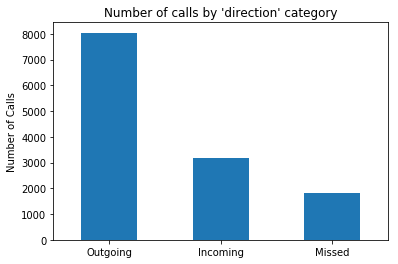

Outgoing    8044
Incoming    3167
Missed      1824
Name: direction, dtype: int64

In [14]:
ax = calls_df['direction'].value_counts().plot.bar()
ax.set_ylabel("Number of Calls")
ax.set_title("Number of calls by 'direction' category")
plt.xticks(rotation=0)
plt.show()

#print value counts for each direction
calls_df['direction'].value_counts()

I will assume that the direction of the call is from the perspective of 'user', i.e. the direction of the call is relative to their phone. For example a call that the 'user' makes from their phone to the other person is outgoing and a call they receive is recorded as incoming. 

It is a little harder to understand what is meant by 'Missed', as it could refer to a call that was not answered by the recipient or it could be one that missed by the 'user'. To investigate further I will use the example of students #5 and #10 again:

In [15]:
get_calls_between_students('#5', '#10').head(16)

There are 97 records in the dataset for this pair of students


,user,other,direction,duration,timestamp
5889,#10,#5,Outgoing,10,2010-11-03 08:13:34+00:00
5925,#5,#10,Incoming,11,2010-11-03 08:13:39+00:00
5976,#10,#5,Outgoing,0,2010-11-04 08:13:40+00:00
5975,#5,#10,Missed,0,2010-11-04 08:14:11+00:00
6130,#10,#5,Outgoing,0,2010-11-05 08:11:56+00:00
6045,#5,#10,Missed,0,2010-11-05 08:12:17+00:00
6401,#10,#5,Outgoing,11,2010-11-09 08:32:12+00:00
6380,#5,#10,Incoming,11,2010-11-09 08:32:16+00:00
6449,#10,#5,Outgoing,0,2010-11-10 08:14:16+00:00
6448,#5,#10,Incoming,0,2010-11-10 08:14:20+00:00


The output shows the first 16 records between students #5 and #10 ordered by timestamp so we can match up the reciprocal records.

We can see that missed calls are normally matched with outgoing calls instead of incoming calls. The time discrepancy between these outgoing and missed calls is slightly larger than between the outgoing-incoming pairing but is close enough to assume that a missed call is from the incoming direction. i.e. it is the student in the 'user' column which has missed the call. 

This assumption also makes sense when you look at the distribution of incoming, outgoing and missed calls in the data set (see bar chart above). One would expect incoming and outgoing calls across the whole dataset to be approximately the same, however, there are many more outgoing calls than incoming calls. 

The outgoing calls matched up with missed calls are all of duration 0 minutes, therefore I will reassign missed calls as incoming for consistency and reduce the bias towards outgoing calls.

In [16]:
#replace 'Missed' with 'Incoming'
calls_df['direction'] = calls_df['direction'].replace({'Missed':'Incoming'})

#print new value counts for each direction
calls_df['direction'].value_counts()

Outgoing    8044
Incoming    4991
Name: direction, dtype: int64

<a id=duration></a>
#### 2.2.4 Duration

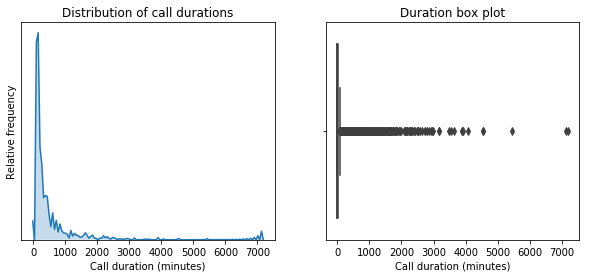

The mean call duration is 59
The median call duration is 8
The mode call duration is 0


In [17]:
def plot_dist_box(df=calls_df):
    fig = plt.figure(figsize=(10,4))
    #plot the distribution of call durations
    ax1 = fig.add_subplot(1,2,1)
    sns.kdeplot(calls_df['duration'],shade=True)
    ax1.set_title("Distribution of call durations")
    ax1.get_yaxis().set_ticks([])
    ax1.set_xlabel("Call duration (minutes)")
    ax1.set_ylabel("Relative frequency")
    ax1.legend().set_visible(False)

    #plot the box plot
    ax2 = fig.add_subplot(1,2,2)
    sns.boxplot(calls_df['duration'])
    ax2.set_title("Duration box plot")
    ax2.set_xlabel("Call duration (minutes)")

    plt.show()

    print(f"The mean call duration is {int(calls_df['duration'].mean())}")
    print(f"The median call duration is {int(calls_df['duration'].median())}")
    print(f"The mode call duration is {int(calls_df['duration'].mode())}")
      
          
plot_dist_box()

The distribution of call duration is positively skewed with a mean call duration of 59 minutes and a median phone call duration of 8 minutes. We can see that there is a long tail with call durations ranging up to 7,000 minutes. 7,000 minutes equates to almost 5 days! It is possible that the call durations are measured in seconds which would considerably reduce the length of this phone call, however, a median call length of 8 seconds seems much less reasonable than a median call length of 8 minutes.

Although length of call could be an important feature for distinguishing close friendships, extremely long phone calls can significantly bias the analysis considering the median value is only 8 minutes. I will set a call duration threshold of 720 minutes (12 hours) to remove outliers above this value. 12 hours still seems a long time for a call but is not unreasonable and only 1.6% of the data lies above this value so removing the outliers will not have an outsized impact on the dataset as a whole. 

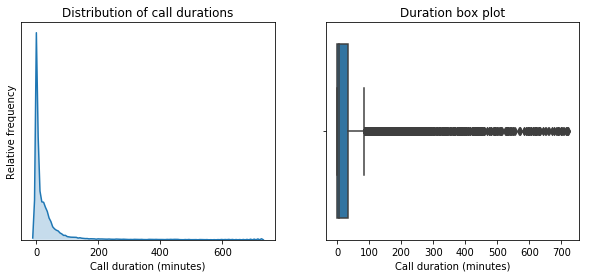

The mean call duration is 34
The median call duration is 7
The mode call duration is 0


In [18]:
#remove outliers
calls_df = calls_df.loc[calls_df['duration']<=720].copy()

#visualise new distribution and boxplot
plot_dist_box()

<a id=ts></a>
#### 2.2.5 Timestamp

The timestamp will be an important feature for identifying students who are becoming more withdrawn overtime. It could also be used to identify stronger relationships between students as close friends will typically call each other at more antisocial times of day (e.g. late evening).

In [19]:
#find the range of years that the dataset covers
years = calls_df['timestamp'].apply(lambda x: x.year) #create new column with the year of the timestamp
years.value_counts()

2010    10483
2011     2312
1980       31
Name: timestamp, dtype: int64

Interestingly we can see that there are 31 records from 1980 and the rest are all from 2010 and 2011. The large gap in data between 1980 and 2010 suggests that this is an error. Investigating the students with records from 1980 more closely it is apparent that all students with a record in 1980, also have records in 2010 or 2011. It seems very unlikely that these students have been at high school for over 30 years! There are only 31 records from 1980 therefore I will simply remove these from the dataset.  

In [20]:
#investigate 1980 records more closely
#create new feature - column with year of call
calls_df['year'] = calls_df['timestamp'].apply(lambda x: x.year)

#get list of users with records in 1980
users_1980 = set(calls_df.loc[calls_df['year']==1980]['user'])

#return a table of summary statistics for students which have records for 1980
print("Summary statistics of 'users' with records in 1980")
round(calls_df.loc[calls_df['user'].isin(users_1980)].groupby(by=['user','year']).describe()['duration'],1)

Summary statistics of 'users' with records in 1980


count  mean   std  min   25%   50%   75%    max
user year                                                 
#11  1980    1.0   6.0   NaN  6.0   6.0   6.0   6.0    6.0
     2010  379.0  28.1  47.6  0.0   0.0  14.0  34.0  512.0
     2011   87.0  29.5  47.7  0.0   3.0  12.0  29.5  240.0
#12  1980   13.0  53.3  87.2  0.0   0.0   4.0  91.0  296.0
     2010  138.0  38.6  97.1  0.0   0.0   3.0  23.8  620.0
     2011   18.0  13.4  18.0  0.0   2.0   6.0  24.0   68.0
#13  1980   10.0  38.7  38.7  0.0  17.0  29.0  50.5  131.0
     2010  243.0  37.1  67.1  0.0   0.0  16.0  49.5  596.0
     2011   81.0  39.4  67.9  0.0   0.0  21.0  45.0  365.0
#17  1980    1.0   8.0   NaN  8.0   8.0   8.0   8.0    8.0
     2010  125.0  24.5  39.8  0.0   0.0  13.0  32.0  241.0
#2   1980    6.0  14.3  19.3  0.0   0.0   5.0  25.8   45.0
     2010   38.0  46.4  90.3  0.0   0.0  18.5  36.0  426.0

In [21]:
#select only records which are not in 1980 and drop year column
calls_df = calls_df.loc[calls_df['year']!=1980].drop('year',axis=1).copy()

#find new frame frame of the data
number_of_days = max(calls_df['timestamp'])-min(calls_df['timestamp'])
print(f"The data covers a period of {number_of_days.days + 1} days between {min(calls_df['timestamp']).date()} and {max(calls_df['timestamp']).date()}")

The data covers a period of 152 days between 2010-09-02 and 2011-01-31


After removing the data from 1980, the dataset now covers a period of 152 days between 2nd September 2010 and 31st January 2011. 

Finally, I will visualise the number and length of calls by time of day to gain an understanding of when phone calls are most likely to be made.


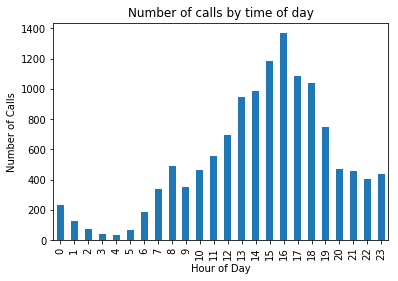

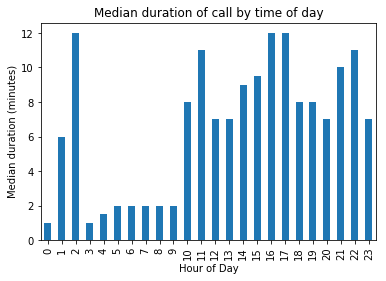

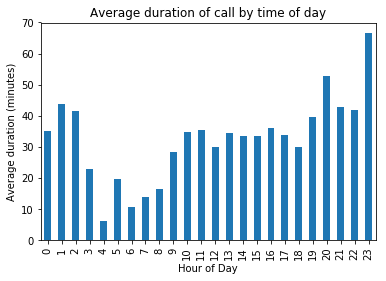

In [22]:
#group calls by time of day
ax = calls_df.groupby(calls_df['timestamp'].dt.hour).count()[['other']].plot.bar()
ax.set_title("Number of calls by time of day")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Number of Calls")
ax.legend().set_visible(False)

#plot the distribution of call durations
ax1 = calls_df.groupby(calls_df['timestamp'].dt.hour).median()[['duration']].plot.bar()
ax1.set_title("Median duration of call by time of day")
ax1.set_xlabel("Hour of Day")
ax1.set_ylabel("Median duration (minutes)")
ax1.legend().set_visible(False)

ax2 = calls_df.groupby(calls_df['timestamp'].dt.hour).mean()[['duration']].plot.bar()
ax2.set_title("Average duration of call by time of day")
ax2.set_xlabel("Hour of Day")
ax2.set_ylabel("Average duration (minutes)")
ax2.legend().set_visible(False)

As would be expected there are more calls in the afternoon and evening and fewer during the night and early morning. It appears that the median and average call times increase later at night. This is consistent with closer friends calling each other late at night as they are talking for longer periods of time. The time of day of the phone call could be a useful feature for determining the strength of friendship, with longer phone calls late at night suggesting stronger relationships.


<a id=dataclean></a>
#### 2.2.6 Summary of data cleaning

During the exploratory data analysis we have carried out the following data cleaning steps:
- replaced student phone numbers with human readable alias
- reassigned 'Missed' calls as 'Incoming calls'
- removed records with duration above 720 minutes (12 hours)
- removed records with timestamps in 1980

<a id=na></a>
### 2.3 Initial Network Analysis

The final part of EDA will be to create a simple visualisation of the network using an undirected and unweighted graph with edges connecting nodes which have a phone call record between them. This will help us 'eye-ball' the relationships in the network before building the model.

In [23]:
#create graph object
G0 = nx.from_pandas_edgelist(calls_df, source='user', target='other')

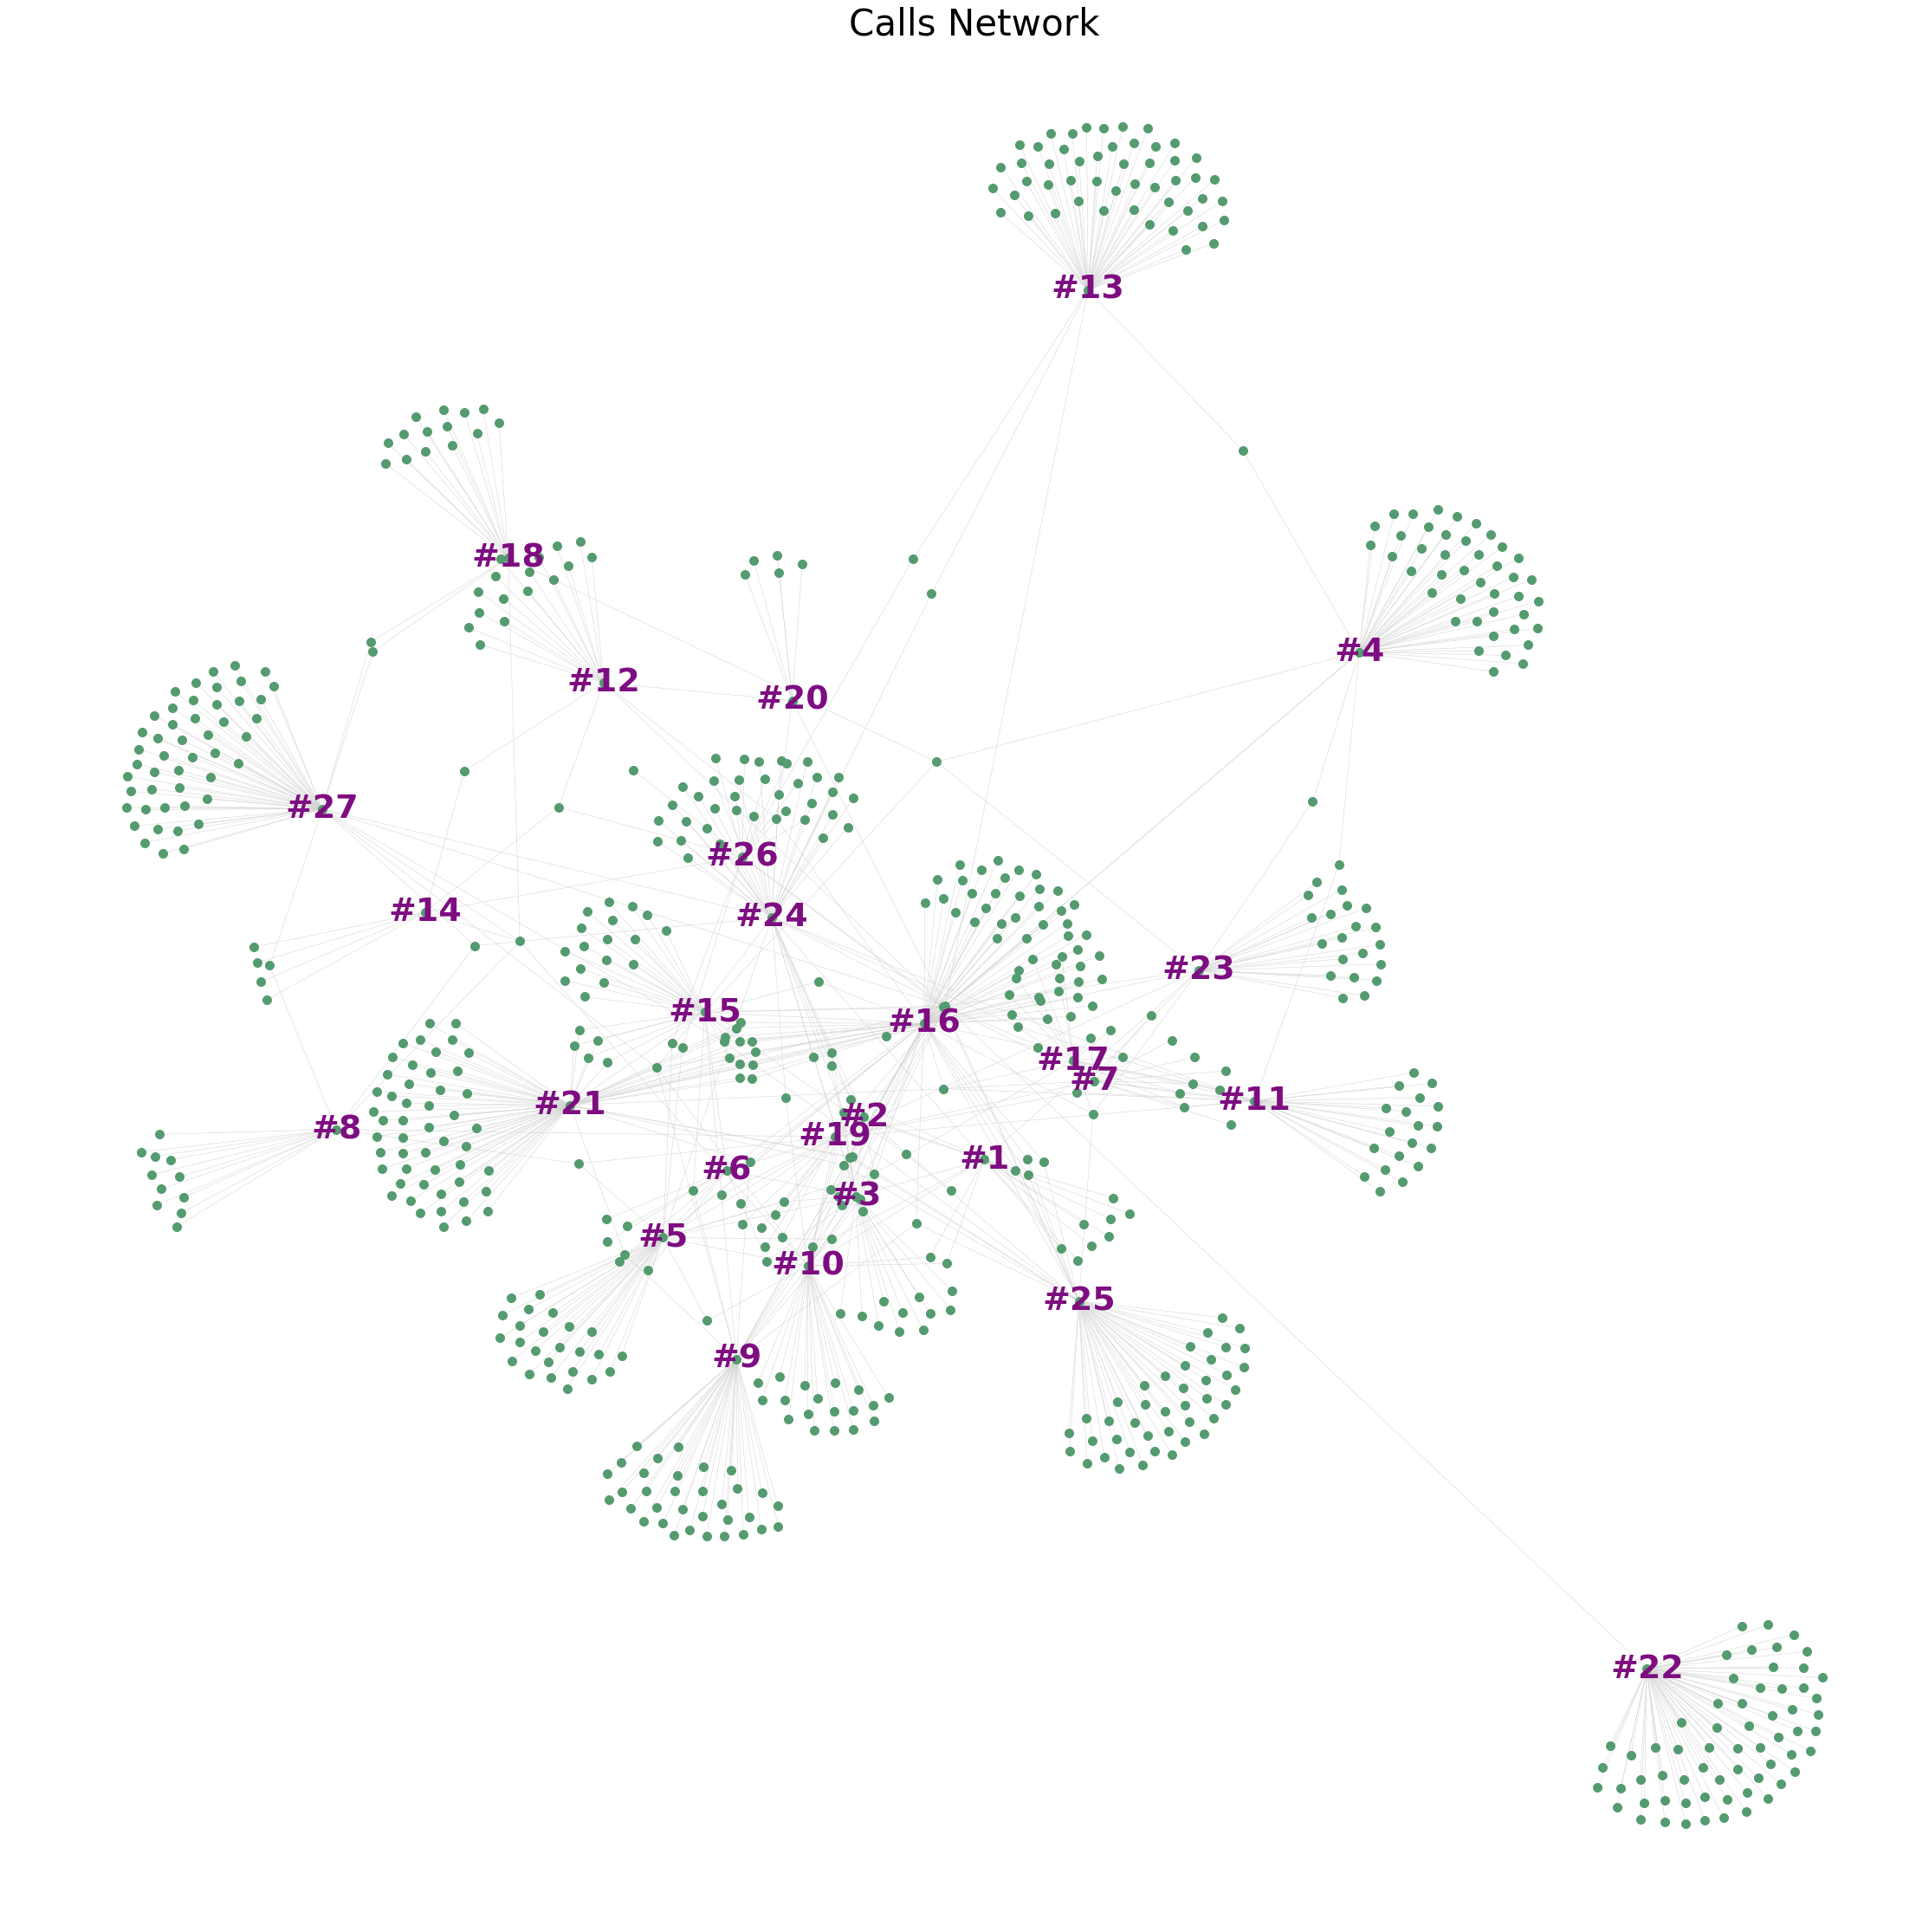

In [24]:
plt.figure(figsize=(30,30))

def create_node_labels(G,user_aliases=user_aliases):
    #assign labels to the nodes which represent students
    node_labels = {}
    for n in G.nodes():
        if n in user_aliases:
            node_labels[n] = n
        else:
            node_labels[n] = ""
    return node_labels

node_labels = create_node_labels(G0)


pos=nx.fruchterman_reingold_layout(G0)
nx.draw(G0,pos=pos,node_size=100,width=0.5,node_color='#549b6f',
        labels=node_labels,font_size=38,font_weight='bold',
        font_color='#7e0d81',edge_color = '#D3D3D3')
plt.title("Calls Network",fontdict={'fontsize': 42,'fontweight' : 5})
plt.show()

The visualisation shows that the network is relatively sparse with most students having many connections to third parties but relatively few have direct connections to other students. It is also apparent that some students have phone calls to common third parties who might be mutual friends outside of the 27 students.

<a id=modelhypothesis></a>
## 3. Modeling hypothesis and reasoning

Now that we understand the key features of the dataset and the information which is available to us, we can start to evaluate a model which finds a paired student for a given student who has been identified as at risk. i.e. If student #1 has been identified as at risk, which other student is most likely to also be having trouble and that the school could proactively reach out to.

The question mentions that there is a tendency suicide-pacts to be formed between friends, and students who become more withdrawn are considered at greater risk. We can therefore split the problem into two main parts:
1. identifying close friends (who might be involved in a suicide-pact together)
2. identifying students who are becoming more withdrawn overtime

__Identifying close friends__

Given the serious nature of a suicide-pact, I will assume that two students would not have a suicide pact if they do not have direct contact with each other. Therefore we can limit the number of students at risk to those who are directly connected to the subject student.

We need to quantify the relationship between connected students in order to predict who is at most risk. There are two competing forces at play when trying to identify a friendship but also identify introverted behvaiour: i) the more phone calls or more time spent on a call between two students the closer one would expect their friendship to be, and ii) students at high risk of depression or suicide will be more withdrawn and therefore not make many phone calls. Therefore, we need to design a measure for friendship which does not have too much of a bias towards extroverted students at the expense of introverted students who may be strongly influenced by a student but don't make that many calls to them in comparison.

I propose using an 'influence' measure to identify how much influence the subject student has over its contacts. This measure will look at the nodes the student is directly connected to and assess what fraction of the node's calls are to the subject student. If a node has a high proportion of its calls to the subject student, then we can say they are influenced by them and more likely to be involved in a suicide pact. By using the proportion of calls we can normalise the number of calls for each node and therefore nodes which are more introverted are not biased against in this friendship measure. For example, if a node connected to the subject student only has made 10 calls in the timeframe, but 9 of them were to the subject student, we can say they are highly influenced by the subject student and are more likely to be at risk. Conversely, a node connected to the subject student which made a 1000 calls in the timeframe, with only 100 to the subject student, although this node may be a better friend to the subject, it is exhibiting extroverted and sociable behaviour and should be considered at less risk.

$$I_{u,v} = \frac{C_{v,u}}{\sum_{i=1}^{i}C_{v,x_i}}    $$

Where:
- $I_{u,v}$ = influence of $u$ over $v$
- $ u $ = subject student identified as being at risk
- $ v $ = node connected to subject student
- $C_{v,u}$ = number of calls between $u$ and $v$
- $C_{v,x_i}$ = number of calls between $v$ and a node $x$ it is connected 
- $i$ = number of nodes $v$ is connected to


__Identifying withdrawn behaviour__

The second part of the metric is identifying which students are becoming more withdrawn and are therefore more at risk of depression. A student might be becoming more withdrawn if they are either making fewer calls than they normally do, or if they are speaking to fewer people than normal. I will calculate the risk of a student being withdrawn using a loneliness risk factor defined below:

$$ L_u = 1 - \frac{X_{u,current} \cdot U_{u,current}}{X_{u,max} \cdot U_{u,max}} $$

Where:
- $ L_u $ = loneliness risk factor of student $u$
- $X_{u,current}$ = number of calls (including external parties) in current previous 30 day window
- $U_{u,current}$ = unique number of people (including external parties) $u$ has spoken to in previous 30 day window
- $X_{u,max}$ = maximum number of calls (including external parties) $u$ has made in any 30 day window
- $U_{u,max}$ = maximum  unique number of people (including external parties) $u$ has spoken to in any 30 day window

The loneliness risk factor takes into account the current behaviour of a student and compares it to the student's maximum activity. If a student is becoming more withdrawn  this ratio will be smaller and indicate a greater change in behaviour recently. The ratio is subtracted from 1 so that students with a lower ratio will have a higher loneliness risk score.

__Calculating a centrality measure for identifying risk__

To calculate the final risk factor for each student we will combine these two metrics:

$$ R_{v,u} = I_{u,v} \cdot L_v $$

Where:
- $ R_{v,u} $ = Risk factor for student $v$ given student $u$ has been identified as at risk
- $ I_{u,v} $ = Influence of $u$ over $v$
- $ L_v $ = Loneliness factor for student $v$


Therefore the centrality measure will take into account both the relative influence the identified student has over other nodes it is connected to, as well as the current behvaiour of each student he/she is connected with. i.e. A student who is heavily influenced by the identified student and is becoming very withdrawn, will have a much higher risk factor and the model will pair this student with the identified student.

<a id=implementation></a>
## 4. Implementation



To implement the centrality measure we will create a set of functions which calculate the influence of a student over its connected nodes and also calculate the count and unique count over a rolling 30 day window to assess the loneliness of each student.

We will define the graph so that the edge weights are equal to the number of calls between two nodes. The edge weights can then be used to calculate the influence metric. As mentioned in the exploratory data analysis section, calls between students are duplicated and not all calls have a reciprocal record and are missing from the dataset. Therefore to calculate the edge weights, if the edge is between two students then the average of recorded calls between then will be used and if the edge is between a student and external party then the count from the student's perspective will be used.

<a id=influence></a>
### 4.1 Calculate influence

In [25]:
def calc_edge_weight(u,v,df=calls_df):
    """
    Calculates the edge weight between two nodes. 
    The edge weight is based on the total count of calls during the timeframe of the dataset.
    """  
    #Filter dataframe for calls from node u to node v and count the number of calls
    u_v = df.loc[(df['user']==u)&(df['other']==v)]['duration'].count()
    #Do the same but for the other possible pairing
    v_u = df.loc[(df['user']==v)&(df['other']==u)]['duration'].count()
    
    if u_v == 0 or v_u == 0: 
        """
        If u_v or v_u is 0, then the pairing is between a student and an external party
        we can just add the two values together
        """
        return int(u_v + v_u)
    else:
        """
        If neither is 0, then it means the pairing is between students
        Note that we can't add them together, as there are duplicated calls. In theory u_v and v_u 
        should be the same (reciprocal calls), however, this is not always the case due to missing
        data so we average the two values.
        """
        
        
        return int((u_v + v_u)/2)
    
    
def add_edge_weights(G):
    """
    Add edge weights for each edge on the graph
    """
    for e in G.edges:
        u,v = e
        try:
            G[u][v]['weight'] = calc_edge_weight(u,v)
        except:
            G[u][v]['weight'] = 0
    return G


def calc_influence(G,u):
    """
    Given a student, u, calculate the influence it has over the nodes it is directly connected to.
    Let v = node u is connected to, calculate the percentage of v's calls which are with u.
    This is a proxy for how much influence u has over v. If v only talks to u, then u has a high 
    influence over v.
    
    Parameters:
    G - networkx Graph object; weighted undirected graph
    u - string; student (e.g. '#1')
    
    Returns:
    scores - dict; dictionary with other students that u has influence over (doesn't include external parties)
                    keys=nodes connected to u, values=fraction of v's calls which were with u.
    """
    assert u in user_aliases
    
    scores = {}
    #loop through direct neighbours of u
    for v in nx.neighbors(G, u):
        
        #if v is another student, calculate the influence score and add to the scores dictionary
        if v in user_aliases:
            
            edge_weight = G[u][v]['weight'] #edge weight between u and v
            total_degree = nx.degree(G, v, 'weight') #total degree of v (calculated using edge weights)
            influence_score = edge_weight/total_degree #fraction of v's calls which are with u

            scores[v] = influence_score
        else:
            pass

    return scores

In [26]:
def ordered_dictionary(d):
    """Order dictionary by values"""
    lists = sorted(d.items(), key = lambda kv:(kv[1], kv[0]),reverse=True)
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    return x,y
    

def plot_all_students_influence(G):
    fig = plt.figure(figsize=(15, 15))
    for index, user in enumerate(user_aliases):
        ax = fig.add_subplot(6, 5, index+1)
        try:
            d = calc_influence(G,user)
            x,y = ordered_dictionary(d)
            
            ax.set_title(user)
            ax.set_yticks([])
            ax.set_ylim(0,0.8)
            
            #add labels to each bar
            for i,j in zip(x,y):
                ax.annotate(str(round(j,2)),xy=(i,j+0.05),ha='center',size=8)

            ax = plt.bar(x,y)
            
        except:
            ax.set_title(user)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.text(0.5,0.5,'No direct \nconnections with \nother students', ha='center', va='center',size = 12,
                   bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 8})

    plt.subplots_adjust(hspace=0.7)

__Visualise student influence__

To check the output of the influence calculations I will plot a graph for each of the students to highlight which other students they have most influence over. Each chart is titled with the subject student and shows the students they are directly connected to with their respective influence score.

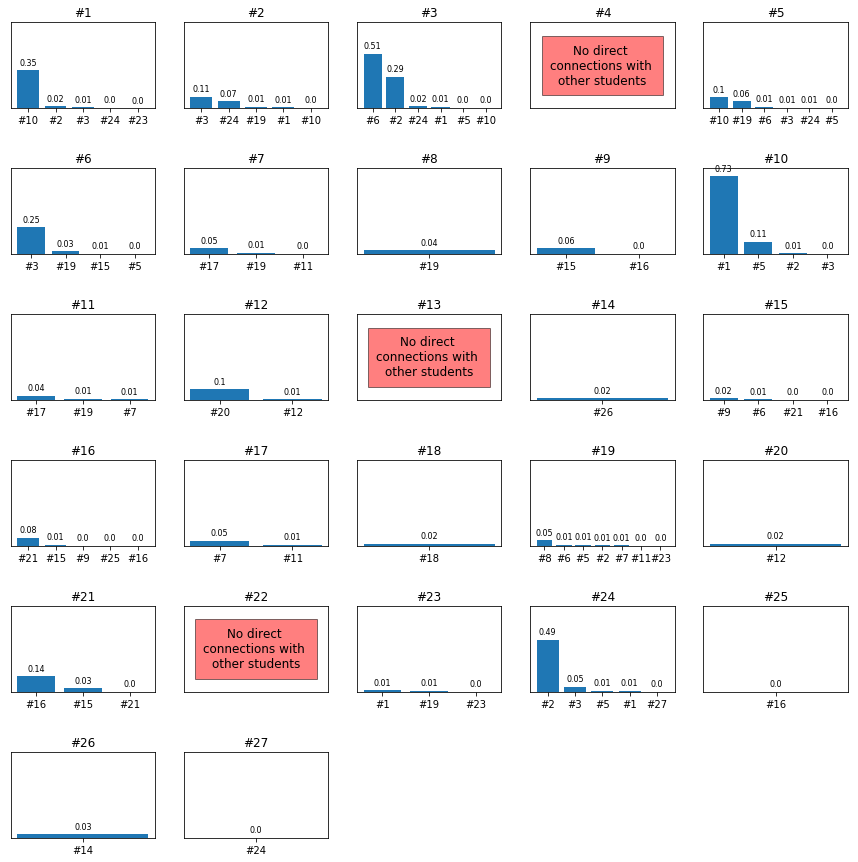

In [27]:
#create undirected unweighted graph from dataframe
Gx = nx.from_pandas_edgelist(calls_df,source='user', target='other',create_using=nx.Graph())
G1 = add_edge_weights(Gx)

display(HTML('<h1>Influence of other students over a particular student</h1>'))
plot_all_students_influence(G1)

The charts above show that each student has some influence over between 0 and 7 other students. Mostly the influence is fairly small, however, there are certain instances, such as for student #10 and student #24, where they have a significant influence over another student. 

It is also important to note that a student will only influence others if they have a direct connection to another student. Students #4, #13 and #22 do not have any direct connections to other students therefore they do not have any influence over other students in the dataset.

<a id=loneliness></a>
### 4.2 Calculate loneliness factor

The loneliness factor for each student will be calculated by measuring whether the student is becoming more or less withdrawn over time.

In [28]:
def filter_dataframe(df,user,direction):
    """ Function to filter dataframe by user and direction"""
    assert user in user_aliases
    assert direction in (['Incoming','Outgoing','all'])
 
    if direction == 'all':
        return df.loc[(df['user'] == user)]
    else:
        return df.loc[(df['user'] == user) & (df['direction'] == direction)]


def calc_rolling_sum(user, df, window=30, direction='all'):
    """ Returns dataframe with data resampled by daily call count with a rolling sum over 
    the specified timeframe (default 30 days)"""

    # filter dataframe by user and direction
    filtered_df = filter_dataframe(df,user,direction)

    # resample for number of calls made in one day
    daily_calls = filtered_df.set_index('timestamp').resample('D').count()[['duration']]
    daily_calls.index = daily_calls.index.date

    # reindex dataframe between start and end date of the the dataset
    min_date = min(df['timestamp']).date()
    max_date = max(df['timestamp']).date()
    daily_calls = daily_calls.reindex(pd.date_range(min_date, max_date))

    # fill nan with 0
    daily_calls = daily_calls.fillna(0)

    # calculate rolling sum over the specified window (30 days)
    daily_calls['rolling_sum'] = daily_calls['duration'].rolling(window).sum()

    return daily_calls[['rolling_sum']][window-1:] #first 30 entries are nan


def calc_rolling_unique(user, df, window=30, direction='all'):
    """ Function to calculate the number of unique persons a student is in contact with over
    a rolling 30 day window"""

    # filter dataframe by user and direction
    filtered_df = filter_dataframe(df,user,direction)
    
    #set timestamp to index and convert timestamp just to a date
    filtered_df = filtered_df.set_index('timestamp')
    filtered_df.index = filtered_df.index.date

    min_date = min(df['timestamp']).date()
    max_date = max(df['timestamp']).date()
    
    ed = max_date  # initial end date
    sd = max_date - rel.relativedelta(days=window)  # initial start date

    #create dictionary to store 30 day rolling unique count
    unique_count = {}
    #Loop through 30 day windows until we reach the first day in the dataset
    while sd >= min_date - rel.relativedelta(days=1):
        #filter dataframe between the specified date window
        calc_df = filtered_df.loc[(filtered_df.index <= ed) & (filtered_df.index > sd)]
        #count unique 'other' numbers
        unique_count[ed] = calc_df['other'].nunique()
        # move window one day backwards
        ed -= rel.relativedelta(days=1)
        sd -= rel.relativedelta(days=1)

        
    # convert dictionary to dataframe
    rolling_unique_calls = pd.DataFrame.from_dict(unique_count, orient='index').sort_index()
    #rename columns
    rolling_unique_calls.rename(columns={0: 'rolling_unique_count'}, inplace=True)
    rolling_unique_calls.rename_axis('timestamp', inplace=True)

    return rolling_unique_calls

These functions calculate the number of calls for each student over a 30 day rolling window and the number of unique people that they are interacting with over a 30 day rolling window. 

The output of these functions for each student is summarised below with each graph showing the rolling count (blue) and rolling unique count (green - plotted on secondary axis) of calls across the time frame of the dataset.

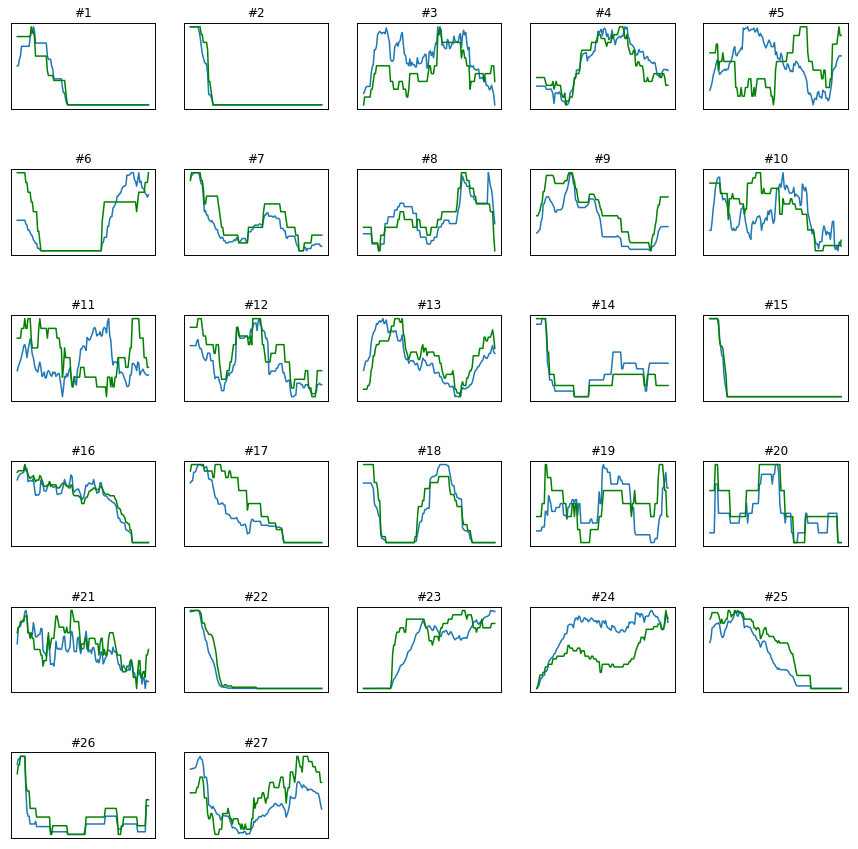

In [49]:
fig = plt.figure(figsize=(15, 15))

display(HTML('<h1>Trends in phone activity for each student over the timeperiod</h1>'))
display(HTML('<h4>Legend:</h4>'))
display(HTML('<p style="color:Blue">Total calls over 30 day rolling window</p>'))
display(HTML('<p style="color:Green">Total unique people contacted over 30 day rolling window (secondary axis)</h1>'))

for index, user in enumerate(user_aliases):
    ax = fig.add_subplot(6, 5, index+1)
    # ax.set_ylim([-1,5])
    ax.set_title(user)
    ax.set_xticks([])
    ax.set_yticks([])
    count = calc_rolling_sum(user,df=calls_df,direction='all')
    ax.plot(count.index, count['rolling_sum'])

    ax1 = ax.twinx()
    ax1.set_xticks([])
    ax1.set_yticks([])
    unique = calc_rolling_unique(user,df=calls_df,direction='all')
    ax1.plot(unique.index, unique['rolling_unique_count'], color='g')

    plt.subplots_adjust(hspace=0.7)

The summary graphs show that the number of calls made over a 30 day window fluctuates for each student. Students #1, #2, #15, #16, #17, #18, #22 and #25 all show zero outgoing calls during the last 30 days. There may be a few reasons for this:
- They have become more withdrawn and are at risk of depression/loneliness
- They have got a new phone and no longer use that phone number any more  

As we do not know which is correct, as a precaution, we must assume it is the former and give these students a higher at risk of loneliness score.

The loneliness metric for each student will now be calculated and stored in a dictionary which can be used for the final calculation of risk.

In [30]:
def loneliness_metrics(df,users=user_aliases,direction='all'):
    """Function calculates various metrics related to 30 count and unique count of calls for each student
    Returns a dictionary with the max and current values for 30 day count and 30 unique calls. The final loneliness
    factor which will be used to define the loneliness of a student is stored as 'factor' in the dictionary"""
    
    max_current={}
    for user in users:
        stats = {}
        count = calc_rolling_sum(user,df=df,direction=direction)
        unique = calc_rolling_unique(user,df=df,direction=direction)
        
        stats['max_count'] = np.max(count['rolling_sum'])
        stats['max_unique'] = np.max(unique['rolling_unique_count'])
        stats['current_count'] = count.ix[-1,'rolling_sum']
        stats['current_unique'] = unique.ix[-1,'rolling_unique_count']
        
        stats['max_factor'] = stats['max_count']*stats['max_unique']
        stats['current_factor'] = stats['current_count']*stats['current_unique']
        
        #calculate ratio of current to max (higher value = less risk of loneliness)
        stats['factor'] = 1- stats['current_factor']/stats['max_factor']
        
        max_current[user]=stats

    return max_current

In [31]:
calls_loneliness_factors = loneliness_metrics(calls_df,direction='all')
#example output of loneliness factors
{k: calls_loneliness_factors[k] for k in list(calls_loneliness_factors)[:2]}

{'#1': {'max_count': 72.0,
  'max_unique': 16,
  'current_count': 0.0,
  'current_unique': 0,
  'max_factor': 1152.0,
  'current_factor': 0.0,
  'factor': 1.0},
 '#2': {'max_count': 38.0,
  'max_unique': 10,
  'current_count': 0.0,
  'current_unique': 0,
  'max_factor': 380.0,
  'current_factor': 0.0,
  'factor': 1.0}}

<a id=predict></a>
### 4.3 Predict paired students

Finally we will write a function to calculate the total risk score for a student given another student has been identified as at risk by multiplying the influence score by the loneliness factors.

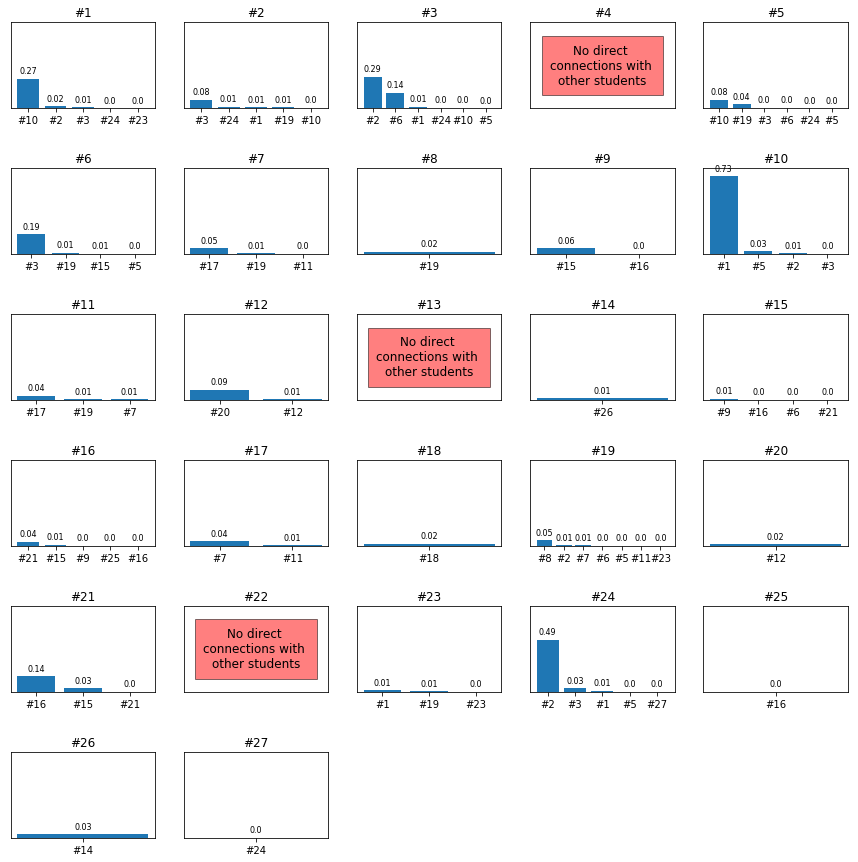

In [50]:
def calc_paired_risk(G,u,loneliness_factors):
    paired_risk = {}
    influence = calc_influence(G,u)
    
    for i in influence:
        paired_risk[i] = influence[i] * loneliness_factors[i]['factor']
     
    return paired_risk


def plot_all_students_paired_risk(G,loneliness_factors):
    fig = plt.figure(figsize=(15, 15))
    for index, user in enumerate(user_aliases):
        ax = fig.add_subplot(6, 5, index+1)
        try:
            d = calc_paired_risk(G,user,loneliness_factors)
            x,y = ordered_dictionary(d)
            
            ax.set_title(user)
            ax.set_yticks([])
            ax.set_ylim(0,0.8)
            
            #add labels to each bar
            for i,j in zip(x,y):
                ax.annotate(str(round(j,2)),xy=(i,j+0.05),ha='center',size=8)

            ax = plt.bar(x,y)

        except:
            ax.set_title(user)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.text(0.5,0.5,'No direct \nconnections with \nother students', ha='center', va='center',size = 12,
                   bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 8})


    plt.subplots_adjust(hspace=0.7)

    
display(HTML('<h1>Final risk scores</h1>'))
plot_all_students_paired_risk(G1,calls_loneliness_factors)

The graphs above show the final risk scores for each student given another student has been identified as at risk. Note that a student must be directly connected to the at risk student for there to be a risk score.

<a id=pairings></a>
### 4.4 Model Pairings

The model will pick the student with the highest risk as the 'paired student'. The pairings predicted by the model are summarised in the 'calls_pairing' dictionary below with the paired student and the risk score listed for each student as the identified student at risk.

In [33]:
def keywithmaxval(d):
    v=list(d.values())
    k=list(d.keys())
    try:
        return (k[v.index(max(v))],round(max(v),4))
    except:
        return ("No pairing",np.nan)
      
def paired_students(G,loneliness_factors,u=user_aliases):
    """ Return dictionary with paired students"""
    paired_students = {}
    for u in user_aliases:
        p = calc_paired_risk(G,u,loneliness_factors)
        paired_students[u] = keywithmaxval(p)
        
    return paired_students

In [34]:
calls_pairing = paired_students(G1,calls_loneliness_factors)
calls_pairing

{'#1': ('#10', 0.2723),
 '#2': ('#3', 0.0805),
 '#3': ('#2', 0.2941),
 '#4': ('No pairing', nan),
 '#5': ('#10', 0.0778),
 '#6': ('#3', 0.1863),
 '#7': ('#17', 0.0543),
 '#8': ('#19', 0.0217),
 '#9': ('#15', 0.0556),
 '#10': ('#1', 0.7273),
 '#11': ('#17', 0.0388),
 '#12': ('#20', 0.0932),
 '#13': ('No pairing', nan),
 '#14': ('#26', 0.0149),
 '#15': ('#9', 0.0134),
 '#16': ('#21', 0.0405),
 '#17': ('#7', 0.0436),
 '#18': ('#18', 0.0189),
 '#19': ('#8', 0.0517),
 '#20': ('#12', 0.0163),
 '#21': ('#16', 0.1439),
 '#22': ('No pairing', nan),
 '#23': ('#1', 0.013),
 '#24': ('#2', 0.4874),
 '#25': ('#16', 0.001),
 '#26': ('#14', 0.0324),
 '#27': ('#24', 0.0005)}

<a id=naviz></a>
### 4.5 Network Visualisation

As the director is only interested finding students who are at risk, given another student has been identified, I will focus the visiualisation on connections between the identified students and the students which the model has predicted could be at risk.

The visualisation will place the identified student at the centre and plot the students potentially at risk around it. To enhance the visualisation the edge lengths, edge widths, nodes sizes and node colours will be enhanced to convey further information about the relationship between the central node and the connected students:

- __Edge length__ - inversely proportional to the influence of the central node over the connected node. i.e. The closer the connected node is to the central node, the more influence the central node has over it.
- __Edge widths__ - proportional to the __loneliness factor__ of the student. i.e. The thicker the edge, the more lonely the connected student is likely to be.
- __Node size__ - proportional to __overall risk__ of the student predicted by the model. i.e. Nodes with larger sizes are predicted to be more at risk.
- __Node colour__ - colour map to highlight the __overall risk__ of the student predicted by the model. i.e. Nodes with higher risk will be coloured darker


As an example I will use student #3 as the student that has already been identified as at risk.

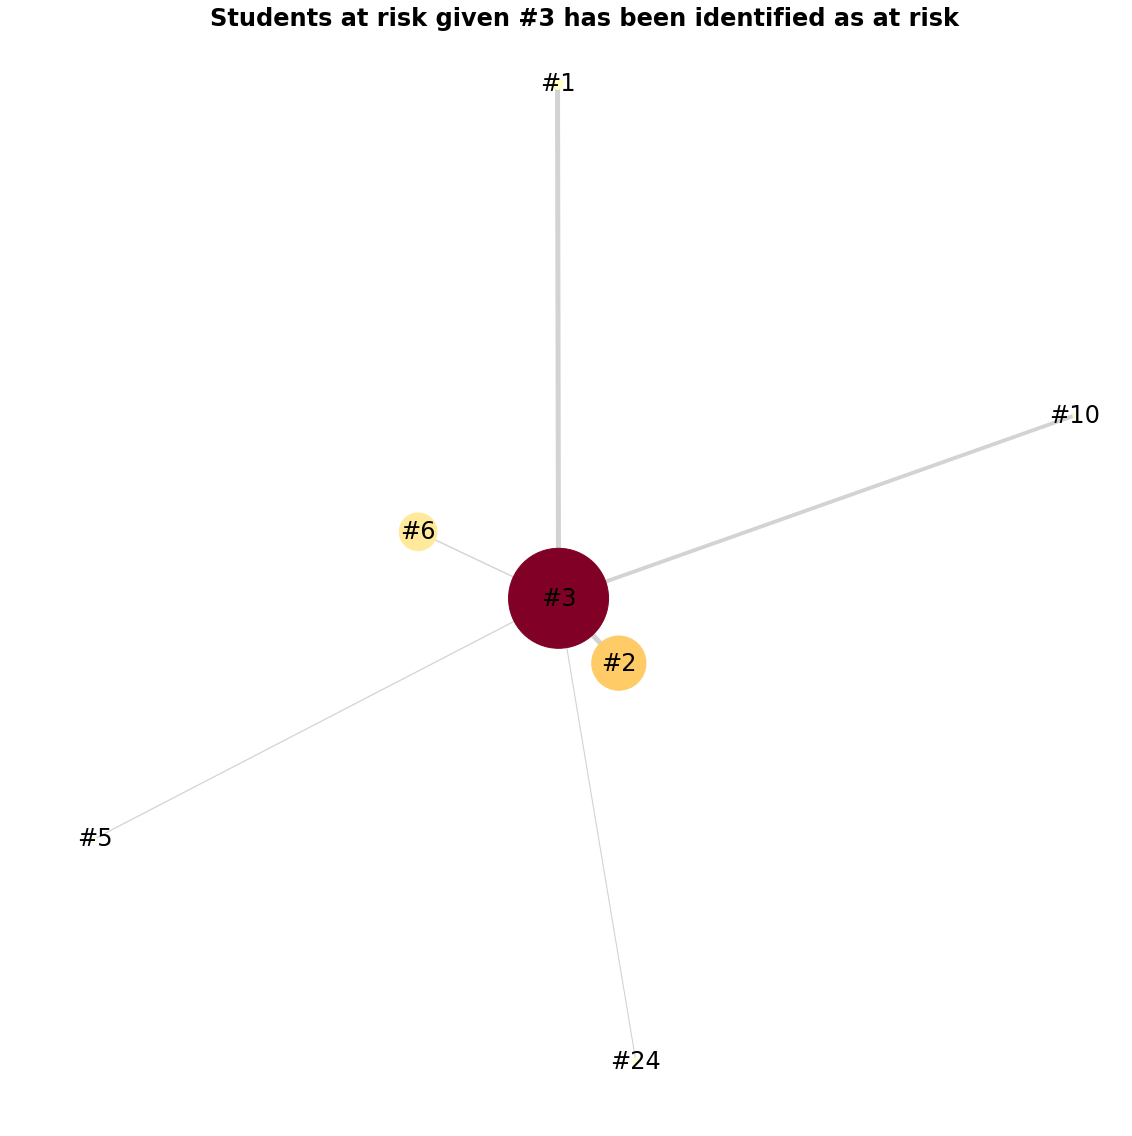

In [35]:
def plot_visualisation(u,paired_risk,df=calls_df,user_aliases=user_aliases,loneliness_factors = calls_loneliness_factors):

    #filter dataset for calls involving the identified student with other students
    df = df.loc[((df['user']=='#3')&df['other'].isin(user_aliases)) |
                     (calls_df['other']=='#3')]
    
    #create graph object from filtered dataframe (edges only between identified students and other connected students)
    G2 = nx.from_pandas_edgelist(df,'user','other')
    
    
    #-------------
    # Add edge weights (proportional to influence)
    #-------------
    weights = calc_influence(G1,'#3')
    for e in G2.edges:
        G2[e[0]][e[1]]['weight'] = weights[e[1]]
     
    
    #-------------
    # Define edge widths (proportional to loneliness of the connected node)
    #-------------
    edge_widths = []
    for e in G2.edges:
        edge_widths.append(calls_loneliness_factors[e[1]]['factor']*5)
        
    #-------------
    # Define node size
    #-------------
    node_sizes = []    
    for n in G2.nodes:
        if n in paired_risk.keys():
            node_sizes.append(paired_risk[n]*10000)
        else:
            #central node
            node_sizes.append(10000)
            
            
    #-------------       
    #Define graph to plot
    #-------------
    #plot 'ego' graph with identified student in the middle
    a = nx.ego_graph(G2,'#3',radius=1,distance='weight')
    
    node_labels = create_node_labels(a)
    pos=nx.fruchterman_reingold_layout(a)
    
    #Put identified student in the middle
    pos[u] = np.array([0,0])
    
    nx.draw(a,pos=pos,with_labels = True,labels=node_labels,
            width=edge_widths,node_size=node_sizes,cmap=plt.cm.YlOrRd, node_color=node_sizes,
            font_size=24, font_color='#000000',edge_color = '#D3D3D3')
    
    plt.title(f"Students at risk given student {u} has been identified as at risk",fontdict={'fontsize':24,'fontweight':'bold'})

    
plt.figure(figsize=(15,15))
paired_risk = calc_paired_risk(G1,'#3',calls_loneliness_factors)
plot_visualisation('#3',paired_risk)


From the visualisation we can imediately see that #3 is connected to students #1, #2, #5, #6, #10 and #25. Student #3 is the central node as it has been identified as being at risk. It is also the largest and darkest coloured node because we already know #3 is at risk (of the nodes present it has the highest probability of being in trouble). Student #2 is the most at risk student, shown by the second darkest colour and second largest node size (after node #3), followed by student #6. We can also see that #1, #5, #10 and #24 are not considered at much risk, even though they are connected to #3, as they have very small node sizes. 

The network also conveys the information about the influence #3 has over each node (length of edge) and loneliness  of each node (width of edge) which was used to calculate the overall risk. For example, nodes #1 and #10 have thick edges which means that although they are not considered at risk due to #3, they are stil relatively 'lonely'. We can also see the #3 has the most influence over #6 as it is the closed node to the center, however, #2 is most at risk because of its higher loneliness score (thicker edge width).

This visualisation could be easily generated for any given student to highlight which students are considered at most risk.

<a id=evaluation></a>
### 4.6 Model Evaluation

Although we do not have the ground truth to verify the model, we have a complementary dataset containing the text messages sent by the 27 students. I will apply the model to the messages dataset to see if the same predictions are made by the model. 

<a id=messages></a>
#### 4.6.1 Load and clean messages data

It is important to carry out the same data cleaning processes on the message dataset that were carried out for the calls dataset so we can directly compare the predictions of the model. The only difference in data preparation for the messages dataset is that there are missing values in the 'other' column which I will remove from the data. I will also make sure that the timeperiod of the dataset is the same for both the calls and messages data.

In [36]:
#read csv
#specify dtypes as 'user' is read differently to 'other'
raw_messages_df = pd.read_csv("high_school_messages.csv", dtype={'user':str,'other':str,'direction':str,'duration':int})

#convert timestamp column from object to datetime
raw_messages_df['timestamp'] = pd.to_datetime(raw_messages_df['timestamp'],utc=True)

#rename length column to duration (so functions will still work)
raw_messages_df.rename(columns={'length':'duration'},inplace=True)
raw_messages_df.head()

,user,other,direction,duration,timestamp
0,07610039694,07684763671,Incoming,28,2010-09-15 18:01:54+00:00
1,07641036117,07681546436,Incoming,7,1980-02-11 07:08:49+00:00
2,07641036117,07681546436,Outgoing,6,1980-02-11 07:14:05+00:00
3,07641036117,07981267897,Outgoing,41,2010-09-09 20:43:44+00:00
4,07981267897,07784425582,Outgoing,75,1980-01-07 22:58:28+00:00


In [37]:
#missing values
raw_messages_df.isnull().sum()

user            0
other        6207
direction       0
duration        0
timestamp       0
dtype: int64

In [38]:
#remove missing values
messages_df = raw_messages_df.dropna()
print(f"{len(raw_messages_df)-len(messages_df) } rows with missing data were removed")

#replace student numbers with aliases
messages_df = replace_numbers_with_alias(messages_df)

#remove texts to self
messages_df = remove_self_calls(messages_df)

#filter dataset to same timeframe as the calls
max_date = max(calls_df['timestamp'])
min_date = min(calls_df['timestamp'])
messages_df = messages_df.loc[(messages_df['timestamp']>=min_date)&
                              (messages_df['timestamp']<=max_date)].copy()

6207 rows with missing data were removed
1 rows with communications to themselves were removed


<a id=pairings></a>
#### 4.6.2 Calculate pairings for messages data

Now that the messages data is in much the same format as the calls data, we can apply the same centrality metric calculations to each student and predict a paired student who might also be at risk. The pairings predicted by the model will be stored in the 'message_pairing' dictionary.

In [39]:
#create undirected unweighted graph from dataframe
Gm = nx.from_pandas_edgelist(messages_df,source='user', target='other',create_using=nx.Graph())
#add edge weights
Gm1 = add_edge_weights(Gm)

In [40]:
#calculate loneliness factors (outgoing calls only)
message_loneliness_factors = loneliness_metrics(df=messages_df,direction='Outgoing')

#example output of loneliness factors
{k: calls_loneliness_factors[k] for k in list(calls_loneliness_factors)[:2]}

{'#1': {'max_count': 72.0,
  'max_unique': 16,
  'current_count': 0.0,
  'current_unique': 0,
  'max_factor': 1152.0,
  'current_factor': 0.0,
  'factor': 1.0},
 '#2': {'max_count': 38.0,
  'max_unique': 10,
  'current_count': 0.0,
  'current_unique': 0,
  'max_factor': 380.0,
  'current_factor': 0.0,
  'factor': 1.0}}

In [41]:
#calculate paired student
messages_pairing = paired_students(Gm1,message_loneliness_factors)
messages_pairing

{'#1': ('#10', 0.3313),
 '#2': ('#3', 0.0475),
 '#3': ('#2', 0.3398),
 '#4': ('#19', 0.0),
 '#5': ('#10', 0.0947),
 '#6': ('#3', 0.11),
 '#7': ('#17', 0.0805),
 '#8': ('#19', 0.0518),
 '#9': ('#15', 0.0719),
 '#10': ('#1', 0.8038),
 '#11': ('#17', 0.0575),
 '#12': ('#20', 0.15),
 '#13': ('No pairing', nan),
 '#14': ('#26', 0.053),
 '#15': ('#9', 0.0086),
 '#16': ('#21', 0.0518),
 '#17': ('#7', 0.0528),
 '#18': ('No pairing', nan),
 '#19': ('#8', 0.0482),
 '#20': ('#12', 0.0291),
 '#21': ('#16', 0.1825),
 '#22': ('#3', 0.0),
 '#23': ('#19', 0.0173),
 '#24': ('#2', 0.5631),
 '#25': ('#16', 0.0013),
 '#26': ('#14', 0.125),
 '#27': ('#24', 0.0)}

<a id=predictions></a>
#### 4.6.3 Compare model predictions

We will now combine the predictions from the calls and messages datasets into one table to compare their predictions.

In [42]:
def combine_results(calls_pairing=calls_pairing,messages_pairing=messages_pairing):
    """ Combine calls predictions and messages predictions into the same dictionary
    This will help with displaying the results in a dataframe"""
    d = {}
    for u in user_aliases:
        d[u] = calls_pairing[u] + messages_pairing[u]
    return d


def print_error_statistics(results_df):
    """Print out some model statistics"""
    
    same_pred_pct = results_df['Same Prediction'].value_counts(normalize=True)[True]*100
    print(f"The model predicted the same pairing across the two datasets {same_pred_pct:.2f}% of the time")
    
    same_pred_count = results_df['Same Prediction'].value_counts()[True]
    diff_pred_count = results_df['Same Prediction'].value_counts()[False]
    
    if diff_pred_count == 1:
        p = 'pairing was'
    else:
        p = 'pairings were'
    
    print(f"{same_pred_count} pairings were the same. \n{diff_pred_count} {p} different")

#combine calls and messages pairings into the same dictionary
results = combine_results()
#define multi index columns
columns = pd.MultiIndex.from_product([['Calls','Messages'], ['student', 'score']])
#create dataframe from dictionary of results
results_df = pd.DataFrame.from_dict(results,orient='index',columns=columns)
#rename columns
results_df.rename(columns={0:'student',1:'score'},inplace=True)
#create boolean column to see if the prediction is the same
results_df['Same Prediction'] = results_df['Calls','student']==results_df['Messages','student']

print_error_statistics(results_df)
results_df

The model predicted the same pairing across the two datasets 85.19% of the time
23 pairings were the same. 
4 pairings were different


Calls            Messages         Same Prediction
        student   score     student   score                
#1          #10  0.2723         #10  0.3313            True
#2           #3  0.0805          #3  0.0475            True
#3           #2  0.2941          #2  0.3398            True
#4   No pairing     NaN         #19  0.0000           False
#5          #10  0.0778         #10  0.0947            True
#6           #3  0.1863          #3  0.1100            True
#7          #17  0.0543         #17  0.0805            True
#8          #19  0.0217         #19  0.0518            True
#9          #15  0.0556         #15  0.0719            True
#10          #1  0.7273          #1  0.8038            True
#11         #17  0.0388         #17  0.0575            True
#12         #20  0.0932         #20  0.1500            True
#13  No pairing     NaN  No pairing     NaN            True
#14         #26  0.0149         #26  0.0530            True
#15          #9  0.0134          #9  0.0086            True
#16         #21  0.0405         #21  0.0518            True
#17          #7  0.0436          #7  0.0528            True
#18         #18  0.0189  No pairing     NaN           False
#19          #8  0.0517          #8  0.0482            True
#20         #12  0.0163         #12  0.0291            True
#21         #16  0.1439         #16  0.1825            True
#22  No pairing     NaN          #3  0.0000           False
#23          #1  0.0130         #19  0.0173           False
#24          #2  0.4874          #2  0.5631            True
#25         #16  0.0010         #16  0.0013            True
#26         #14  0.0324         #14  0.1250            True
#27         #24  0.0005         #24  0.0000            True

Comparing the model for the calls and messages data we can see that the model predicts the same pairing 85% of the time. Looking more closely at the results it looks like most of the differences in pairing prediction occurred for students who had no pairing from either the calls data or the message data. A student has no pairing if they do not have direct contact with any other student in the dataset. Therefore if they have contact in the messages data but not the calls data, then they might get a pairing for messages but not calls. This feature of the model could be improved with further refinement so that a pairing is always predicted, however, to compare the models I will remove the instances where no pairing is predicted.

In [43]:
#remove rows with no pairing in either the calls or messages data sets.
results_df_without_no_pairing = results_df.loc[(results_df['Calls','student']!='No pairing')&
                                       (results_df['Messages','student']!='No pairing')]
print_error_statistics(results_df_without_no_pairing)
results_df_without_no_pairing

The model predicted the same pairing across the two datasets 95.65% of the time
22 pairings were the same. 
1 pairing was different


Calls         Messages         Same Prediction
    student   score  student   score                
#1      #10  0.2723      #10  0.3313            True
#2       #3  0.0805       #3  0.0475            True
#3       #2  0.2941       #2  0.3398            True
#5      #10  0.0778      #10  0.0947            True
#6       #3  0.1863       #3  0.1100            True
#7      #17  0.0543      #17  0.0805            True
#8      #19  0.0217      #19  0.0518            True
#9      #15  0.0556      #15  0.0719            True
#10      #1  0.7273       #1  0.8038            True
#11     #17  0.0388      #17  0.0575            True
#12     #20  0.0932      #20  0.1500            True
#14     #26  0.0149      #26  0.0530            True
#15      #9  0.0134       #9  0.0086            True
#16     #21  0.0405      #21  0.0518            True
#17      #7  0.0436       #7  0.0528            True
#19      #8  0.0517       #8  0.0482            True
#20     #12  0.0163      #12  0.0291            True
#21     #16  0.1439      #16  0.1825            True
#23      #1  0.0130      #19  0.0173           False
#24      #2  0.4874       #2  0.5631            True
#25     #16  0.0010      #16  0.0013            True
#26     #14  0.0324      #14  0.1250            True
#27     #24  0.0005      #24  0.0000            True

After removing the students for which the model could not predict a pairing, there was only one student (#23) which had a different prediction. Looking more closely at the predicted risk scores for both datasets, we can see that both models predicted the same students at risk in first and second place (#1 and #19) but their ranking is different. This shows that although the model gave different absolute predictions the predictions were similar.

In [44]:
print(f"Student #23 risk scores (calls) \n{dict(zip(*ordered_dictionary(calc_paired_risk(G1,'#23',calls_loneliness_factors))))}")
print(f"Student #23 risk scores (messages) \n{dict(zip(*ordered_dictionary(calc_paired_risk(Gm1,'#23',message_loneliness_factors))))}")

Student #23 risk scores (calls) 
{'#1': 0.012987012987012988, '#19': 0.007248728767716109, '#23': 7.089578137484062e-05}
Student #23 risk scores (messages) 
{'#19': 0.017250101999184003, '#1': 0.014354066985645933, '#4': 0.0, '#22': 0.0, '#11': 0.0}


<a id=conclusions></a>
## 5 Conclusions

A model has been created which uses the phone records of students in a social network to can identify a "paired" student given that another student has been identified as at risk of suicide.

The model uses a custom defined centrality measure to assign a relative importance to nodes in the network. The measure takes into account the closeness of relationship between nodes (influence) and also the individual behaviour of each node (loneliness). Nodes which are heavily influenced by the student already identified as at risk and who are also exhibiting isolationist behaviour will be assigned a higher importance in the network.

The model was developed using the phone call records of the students. As we do not have access to the 'ground-truth', the model algorithm was applied to a second dataset, the text message records of the same students to see if the model gave similar results. The algorithm predicted the same rankings for at risk students which suggests that the model was not overfit on the training dataset and has some stability on additional data.

#### Model improvements

This is clearly a crude centrality measure for predicting a paired student at risk given a subject student, yet the model has seemed to perform consistently across two different sets of data. There are a number of other factors which could be incorporated into the model to refine the predictions. For example:
- incorporate the time of day or length of calls between students into the influence measure. Calls at antisocial hours could be given more weighting as they signify a closer relationship
- compare the current number of calls/unique calls in the loneliness factor to a moving average rather than the maximum values as the maximum values could just be anomalies
- impute missing data (e.g. inserting reciprocal records for unmatched incoming and outgoing calls) to improve the stability of the model
- account for weak ties between students, i.e. friends of friends, so the influence of the subject node reaches further than just the nodes it is directly connected to. This would help find a pairing for students how do not directly talk to other students but might have mutual friends
